# Simulate molecular ground state with quantum algorithms

In this example, we'll simulate the molecular ground state of caffeine and hydrogen (H2) using Quantum Phase Estimation (QPE) and Variational Quantum Eigensolver (VQE). We'll show how many quantum resources (qubits, gates) the different approaches require and run the results on a quantum simulator.

To read more about these two algorithms, take a look at our blog post on the Q# Dev blog: [Quantum developer tools for chemistry](https://devblogs.microsoft.com/qsharp/quantum-developer-tools-for-chemistry/).

In [1]:
import qsharp
from qdk.chemistry import Molecule
from qdk.chemistry.broombridge import load_and_encode
qsharp.reload()
from Microsoft.Quantum.Chemistry.QPE import GetEnergyQPE
from Microsoft.Quantum.Chemistry.VQE import GetEnergyVQE

Adding package microsoft.quantum.chemistry.jupyter.

Reloading workspace.

### 1. Load molecule

In [2]:
caffeine = Molecule.from_xyz("../data/xyz/caffeine.xyz")

In [3]:
caffeine

JsmolWidget(layout=Layout(align_self='stretch', height='400px'))

In [4]:
caffeine.num_electrons

102

### 2. Load Broombridge and simulate in Q#

In [5]:
encoded_data_caffeine = load_and_encode("../data/broombridge/caffeine.yaml")

### 3. Simulate energy of Caffeine molecule

In [6]:
%%time
GetEnergyQPE.simulate(
    JWEncodedData=encoded_data_caffeine,
    nBitsPrecision=7,
    trotterStepSize=0.4,
    trotterOrder=1)

CPU times: user 2.4 ms, sys: 2.76 ms, total: 5.17 ms
Wall time: 850 ms


882.6628565016248

In [7]:
%%time
resources_caffeine_qpe = GetEnergyQPE.estimate_resources(
    JWEncodedData=encoded_data_caffeine, 
    nBitsPrecision=7,
    trotterStepSize=0.4, 
    trotterOrder=1)
resources_caffeine_qpe

CPU times: user 2.86 ms, sys: 4.4 ms, total: 7.26 ms
Wall time: 1.78 s


{'CNOT': 211616,
 'QubitClifford': 124794,
 'R': 81068,
 'Measure': 317,
 'T': 0,
 'Depth': 0,
 'Width': 5,
 'QubitCount': 5,
 'BorrowedWidth': 0}

### 4. Compare resources to a smaller circuit (VQE)

In [8]:
GetEnergyVQE.simulate(
    JWEncodedData=encoded_data_caffeine,
    theta1=0.001,
    theta2=-0.001,
    theta3=0.001,
    nSamples=1
)

882.3912532826445

In [9]:
resources_caffeine_vqe = GetEnergyVQE.estimate_resources(
    JWEncodedData=encoded_data_caffeine,
    theta1=0.001,
    theta2=-0.001,
    theta3=0.001,
    nSamples=1
)
resources_caffeine_vqe

{'CNOT': 0,
 'QubitClifford': 52,
 'R': 0,
 'Measure': 130,
 'T': 0,
 'Depth': 0,
 'Width': 4,
 'QubitCount': 4,
 'BorrowedWidth': 0}

### Simulate a smaller molecule: H2

52 Clifford gates is still a lot of resources, and won't be feasible on near-term hardware. Let's simulate a smaller molecule to compare the required resources to caffeine.

In [10]:
H2 = Molecule.from_smiles("[H][H]")

Solution did not converge. Lowest energy found: -1.0


In [11]:
H2

JsmolWidget(layout=Layout(align_self='stretch', height='400px'))

$H_2$ has a much smaller number of electrons than caffeine, as shown below:

In [12]:
H2.num_electrons

2

In [13]:
encoded_data_h2 = load_and_encode("../data/broombridge/hydrogen_0.2.yaml")

In [14]:
%%time
GetEnergyQPE.simulate(
    JWEncodedData=encoded_data_h2, 
    nBitsPrecision=7,
    trotterStepSize=0.4,
    trotterOrder=1
)

CPU times: user 2.61 ms, sys: 2.18 ms, total: 4.79 ms
Wall time: 376 ms


-1.1419413817622361

In [15]:
resources_h2_qpe = GetEnergyQPE.estimate_resources(
    JWEncodedData=encoded_data_h2, 
    nBitsPrecision=7,
    trotterStepSize=0.4,
    trotterOrder=1
)
resources_h2_qpe

{'CNOT': 99584,
 'QubitClifford': 50106,
 'R': 43724,
 'Measure': 317,
 'T': 0,
 'Depth': 0,
 'Width': 5,
 'QubitCount': 5,
 'BorrowedWidth': 0}

In [16]:
GetEnergyVQE.simulate(
    JWEncodedData=encoded_data_h2, 
    theta1=0.001,
    theta2=-0.001,
    theta3=0.001,
    nSamples=1
)

-1.1166856359999997

In [17]:
resources_h2_vqe = GetEnergyVQE.estimate_resources(
    JWEncodedData=encoded_data_h2, 
    theta1=0.001,
    theta2=-0.001,
    theta3=0.001,
    nSamples=1
)
resources_h2_vqe

{'CNOT': 0,
 'QubitClifford': 28,
 'R': 0,
 'Measure': 70,
 'T': 0,
 'Depth': 0,
 'Width': 4,
 'QubitCount': 4,
 'BorrowedWidth': 0}

### Comparing resources

The below bar chart shows the comparison between number of Clifford gates for the different algorithms on both Caffeine and H2.

Text(0.5, 1.0, 'Resources for H2 vs Caffeine')

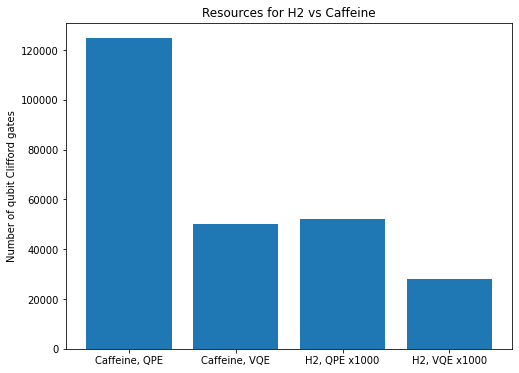

In [18]:
import matplotlib
import pylab as pl
%matplotlib inline

pl.figure(figsize=(8, 6))
pl.bar(
    [
        "Caffeine, QPE",
        "Caffeine, VQE",
        "H2, QPE x1000",
        "H2, VQE x1000",
    ],
    [
        resources_caffeine_qpe["QubitClifford"],
        resources_h2_qpe["QubitClifford"],
        resources_caffeine_vqe["QubitClifford"] * 1e3,
        resources_h2_vqe["QubitClifford"] *  1e3,
    ]
)
pl.ylabel("Number of qubit Clifford gates")
pl.title("Resources for H2 vs Caffeine")

### Estimate ground state

The smallest circuit of the 4 aforementioned is VQE on H2. However, it's still quite large and will require some state-of-the-art fine-tuned quantum hardware. To be able to run the sample on hardware, let's try to make it even smaller.

In [19]:
prepare_state = qsharp.compile("""open Microsoft.Quantum.Core;
open Microsoft.Quantum.Chemistry;
open Microsoft.Quantum.Chemistry.JordanWigner;
open Microsoft.Quantum.Chemistry.JordanWigner.VQE;
open Microsoft.Quantum.Intrinsic;
open Microsoft.Quantum.Diagnostics;

operation PrepareStateVQE (JWEncodedData: JordanWignerEncodingData, theta1: Double, theta2: Double, theta3: Double) : Unit {
    let (nSpinOrbitals, fermionTermData, inputState, energyOffset) = JWEncodedData!;
    let (stateType, JWInputStates) = inputState;
    let inputStateParam = (
        stateType,
        [
            JordanWignerInputState((theta1, 0.0), [2, 0]), // singly-excited state
            JordanWignerInputState((theta2, 0.0), [3, 1]), // singly-excited state
            JordanWignerInputState((theta3, 0.0), [2, 3, 1, 0]), // doubly-excited state
            JWInputStates[0] // Hartree-Fock state from Broombridge file
        ]
    );
    use qubits = Qubit[nSpinOrbitals];
    PrepareTrialState(inputStateParam, qubits);
    DumpRegister((), qubits); // Display the simulated value of the qubit register
    ResetAll(qubits);
}""")

Prepare the base UCCSD input state

In [20]:
qsharp.config["dump.basisStateLabelingConvention"] = "bitstring"

In [21]:
prepare_state.simulate(JWEncodedData=encoded_data_h2, theta1=0.001, theta2=-0.001, theta3=0.001, nSamples=1)

|0000⟩	0 + 0𝑖
|0001⟩	0 + 0𝑖
|0010⟩	0 + 0𝑖
|0011⟩	0 + 0𝑖
|0100⟩	0 + 0𝑖
|0101⟩	-0.0009999985000033677 + -1.3571111484639956E-19𝑖
|0110⟩	0 + 0𝑖
|0111⟩	0 + 0𝑖
|1000⟩	0 + 0𝑖
|1001⟩	0 + 0𝑖
|1010⟩	0.0009999985000033683 + -3.5546677115099624E-19𝑖
|1011⟩	0 + 0𝑖
|1100⟩	0.9999985000033751 + -5.723123884964407E-17𝑖
|1101⟩	0 + 0𝑖
|1110⟩	0 + 0𝑖
|1111⟩	0.000999998500003381 + 1.639149688420182E-18𝑖

()

The ground state seems to be very close to |1100>! Let's prepare that state instead.

In [22]:
prepare_state_simple = qsharp.compile("""open Microsoft.Quantum.Core;
open Microsoft.Quantum.Chemistry;
open Microsoft.Quantum.Chemistry.JordanWigner;
open Microsoft.Quantum.Chemistry.JordanWigner.VQE;
open Microsoft.Quantum.Intrinsic;
open Microsoft.Quantum.Diagnostics;

operation PrepareStateVQE (JWEncodedData: JordanWignerEncodingData) : Unit {
    let (nSpinOrbitals, fermionTermData, inputState, energyOffset) = JWEncodedData!;
    use qubits = Qubit[nSpinOrbitals];
    X(qubits[0]);
    X(qubits[1]);
    DumpRegister((), qubits); // Display the simulated value of the qubit register
    ResetAll(qubits);
}""")

In [23]:
prepare_state_simple.simulate(JWEncodedData=encoded_data_h2)

|0000⟩	0 + 0𝑖
|0001⟩	0 + 0𝑖
|0010⟩	0 + 0𝑖
|0011⟩	0 + 0𝑖
|0100⟩	0 + 0𝑖
|0101⟩	0 + 0𝑖
|0110⟩	0 + 0𝑖
|0111⟩	0 + 0𝑖
|1000⟩	0 + 0𝑖
|1001⟩	0 + 0𝑖
|1010⟩	0 + 0𝑖
|1011⟩	0 + 0𝑖
|1100⟩	1 + 0𝑖
|1101⟩	0 + 0𝑖
|1110⟩	0 + 0𝑖
|1111⟩	0 + 0𝑖

()

In [24]:
prepare_state_simple.estimate_resources(JWEncodedData=encoded_data_h2)

{'CNOT': 0,
 'QubitClifford': 2,
 'R': 0,
 'Measure': 4,
 'T': 0,
 'Depth': 0,
 'Width': 4,
 'QubitCount': 4,
 'BorrowedWidth': 0}

This is much more reasonable to run on near-term hardware. Let's use this ground state preparation to run this sample on real quantum hardware in the next notebook: <a href="../Hamiltonian/Approximate Energy using Jordan-Wigner transformation.ipynb">Hamiltonian/Approximate Energy using Jordan-Wigner transformation.ipynb</a>.